<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Regularization

_Authors: Kiefer Katovich (SF)_

_Modifications for DSI-East by Justin Pounders_

---

### Lesson Guide
- [Overview of regularization](#intro)
- [What is the effect of regularization](#effect)
- [Standardizing predictors is required](#standardization)
- [Visualizing the Ridge](#viz-ridge)
- [Visualizing the Lasso](#viz-lasso)
- [Visualizing the Elastic-Net](#viz-elastic-net)
- [Model performance with complex predictor matrix using regularization](#model-performance)

In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id='intro'></a>

## Overview of regularization

---

The goal of "regularizing" regression models is to structurally prevent overfitting by imposing a penalty on the coefficients of the model.

Regularization methods like the Ridge and Lasso add this additional "penalty" on the size of coefficients to the loss function. When the loss function is minimized, this additional component is added to the residual sum of squares.

In other words, the minimization becomes a balance between the error between predictions and true values and the size of the coefficients. 

The two most common types of regularization are the **Lasso**, **Ridge**. There is a mixture of them called the **Elastic Net**. We will take a look at the mathematics of regularization and the effect these penalties have on model fits.


<a id='effect'></a>

## What is the effect of regularization?

---

**To demonstrate the effects we will be using a dataset on wine quality.**

An important aspect of this data, which is a reason why we might choose to use regularization, is that there is **multicollinearity** in the data. The term multicollinearity means that there are high correlations between predictor variables in your model. 

**This can lead to a variety of problems including:**
1. The effect of predictor variables estimated by your regression will depend on what other variabes are included in your model.
2. Predictors can have wildly different effects depending on the observations in your sample, and small changes in samples can result in very different estimated effects.
3. With very high multicollinearity, the inverse matrix the computer calculates may not be accurate.
4. We can no longer interpret a coefficient on a variable as the effect on the target of a one unit increase in that variable holding the other variables constant. This is because when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.

The Ridge is best suited to deal with multicollinearity. Lasso also deals with multicollinearity between variables, but in a more brutal way (it "zeroes out" the less effective variable).

The Lasso is particularly useful when you have redundant or unimportant variables. If you have 1000 variables in a dataset the Lasso can perform "feature selection" automatically for you by forcing coefficients to be zero.

### Load the wine csv

This version has red and white wines concatenated together and tagged with a binary 1,0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [34]:
wine = pd.read_csv('./datasets/winequality_merged.csv')

# replace spaces in column names and convert all columns to lowercase:
wine.columns = [x.lower().replace(' ', '_') for x in wine.columns]

In [35]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [36]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
fixed_acidity           6497 non-null float64
volatile_acidity        6497 non-null float64
citric_acid             6497 non-null float64
residual_sugar          6497 non-null float64
chlorides               6497 non-null float64
free_sulfur_dioxide     6497 non-null float64
total_sulfur_dioxide    6497 non-null float64
density                 6497 non-null float64
ph                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
red_wine                6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 659.9 KB


**Look at the correlation between variables.**

In [37]:
wine_corr = wine.corr()

In [38]:
wine_corr

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
ph,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


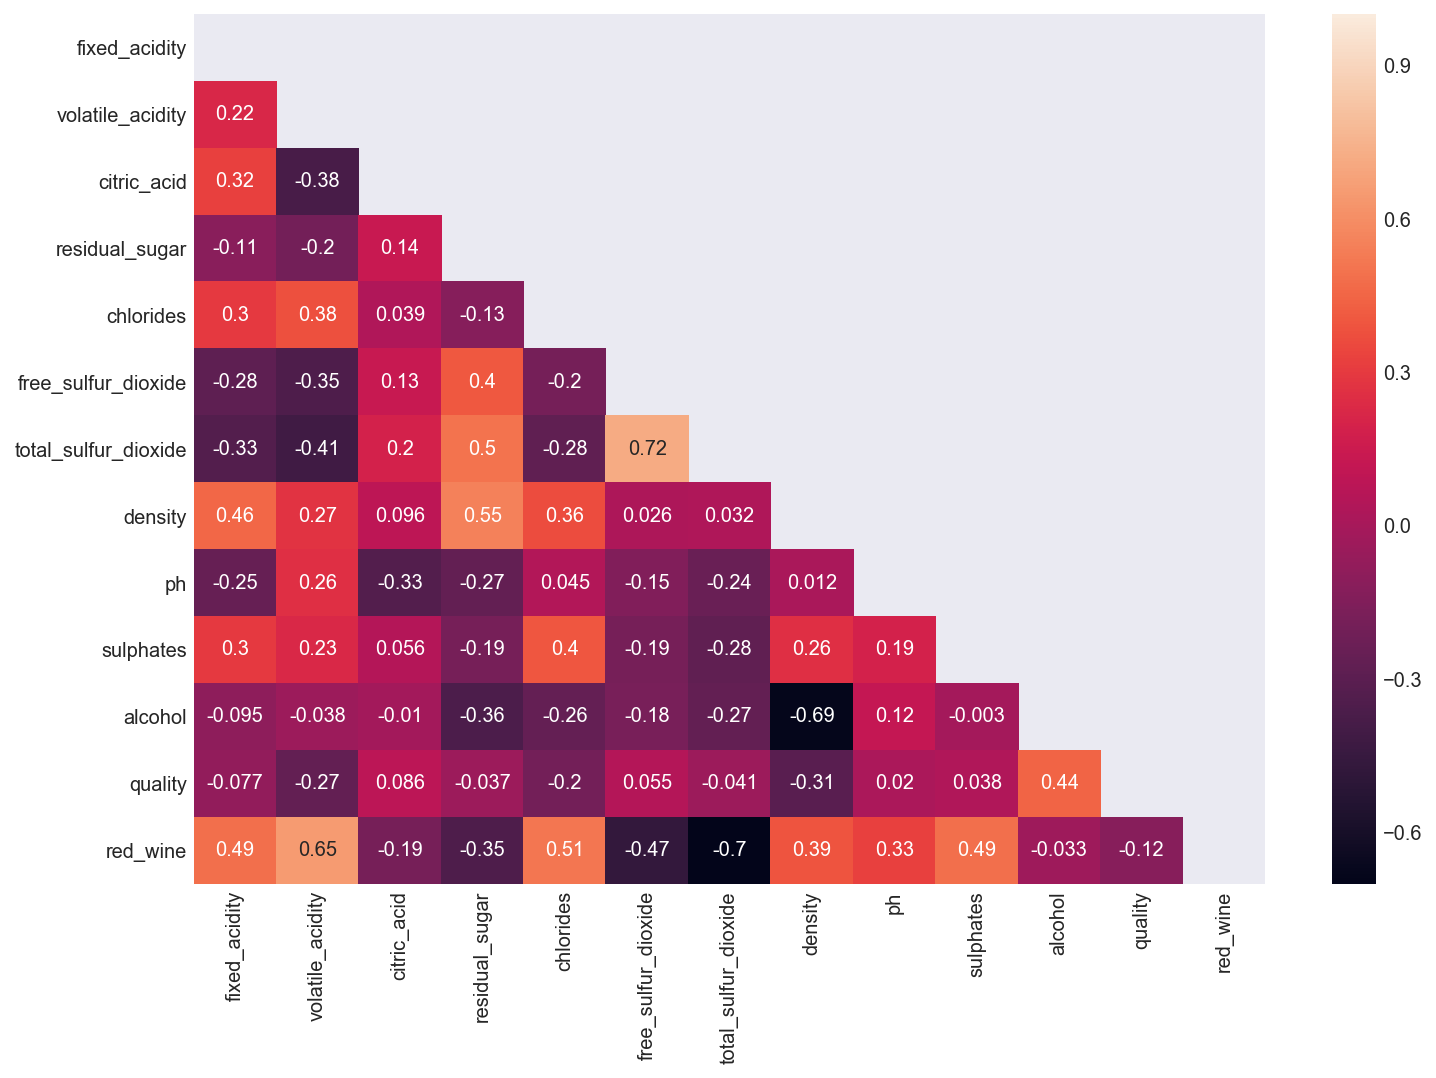

In [39]:
plt.figure(figsize=(12,8))

mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(wine_corr, annot=True, mask=mask)

The correlation matrix can be hard to take in if you have a lot of features.  Let's visualize it.

**Note**: this is a common visualization in EDA building up to modeling.  You may want to stash this code cell to a "cheat sheet"/recipe file for future use!

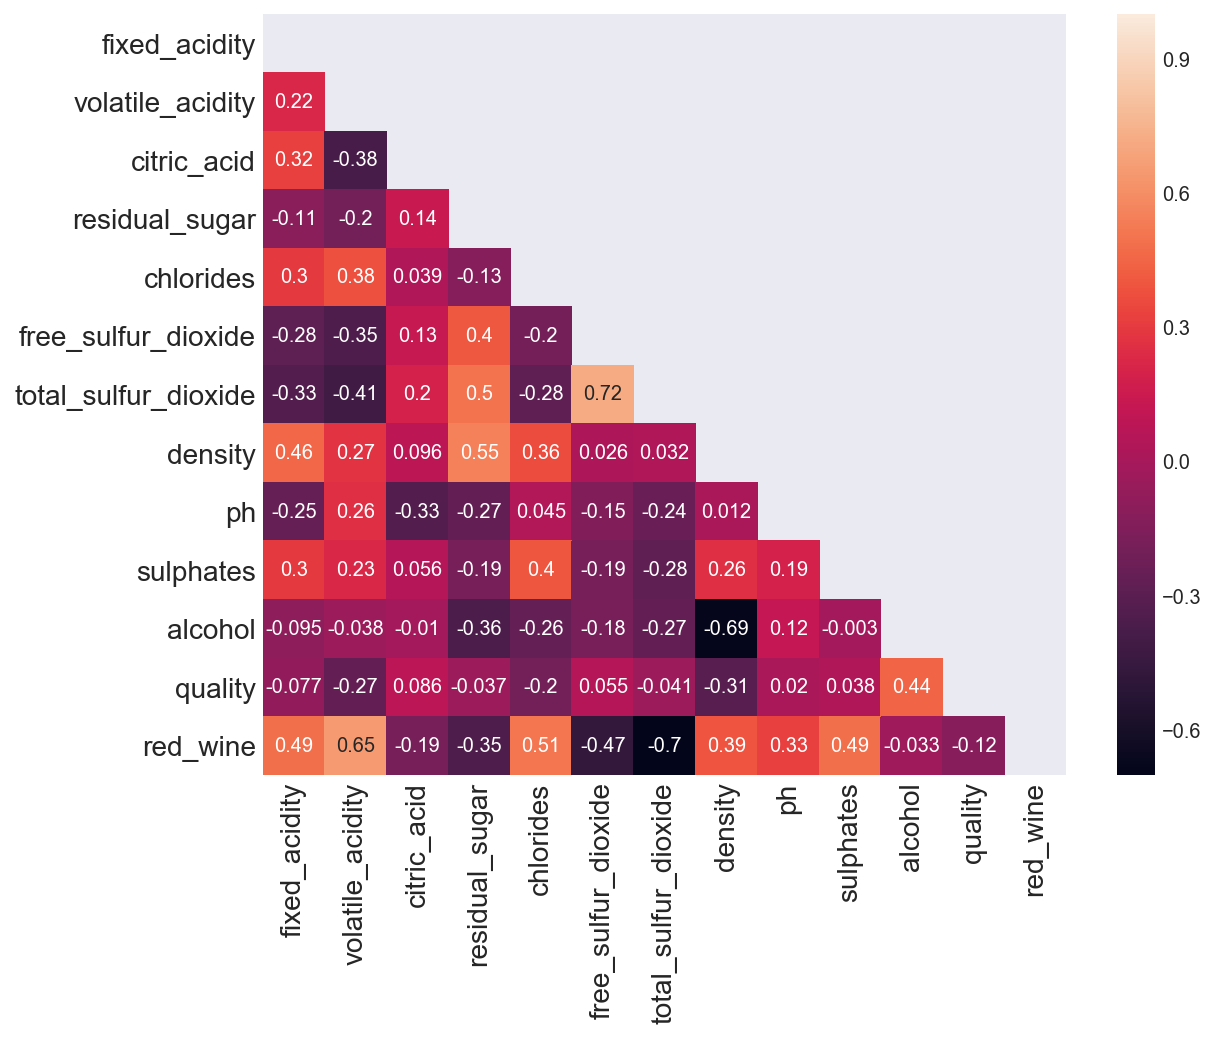

In [40]:
# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(wine_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(wine_corr, mask=mask, ax=ax, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<a id='standardization'></a>

## Standardizing predictors is required

---

With the Lasso and Ridge it is neccessary to standardize the predictor columns before constructing the models, even the dummy coded categorical variables. 

Below we define our target variable and then normalize the columns that are not the target.

Recall the equations for the Ridge and Lasso penalties:

### $$ \text{Ridge penalty}\; = \alpha \sum_{j=1}^p \beta_j^2$$

### $$ \text{Lasso penalty}\; = \alpha \sum_{j=1}^p |\beta_j|$$

**Check: How are the $\beta$ coefficients affected by the mean and variance of your variables?**

In [41]:
# Choose a target/dependent variable that we will predict
target = 'quality'

In [42]:
# select all the columns that are not the target
nc = [x for x in wine.columns if x != target]
print(nc)

# By subtracting the mean and dividing by the standard devation, the normalization procedure is putting 
# all of the predictor variables on the same scale (distributions with mean == 0 and standard deviation == 1).
# Do this in Pandas.
# (Yes, we could use sklearn's StandardScaler as well.  Try it and see if you get the same answer!)
wine.loc[:, nc] = (wine.loc[:, nc] - wine.loc[:, nc].mean())/wine.loc[:, nc].std()

['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'red_wine']


In [43]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,5,1.750055
1,0.451001,3.281982,-2.192664,-0.597594,1.197883,-0.311296,-0.862402,0.701432,-0.115064,0.999502,-0.580023,5,1.750055
2,0.451001,2.553104,-1.917405,-0.660648,1.026618,-0.874695,-1.092402,0.768128,0.258100,0.797897,-0.580023,5,1.750055
3,3.073580,-0.362411,1.660957,-0.744721,0.541370,-0.762016,-0.986248,1.101609,-0.363840,0.327485,-0.580023,6,1.750055
4,0.142462,2.188664,-2.192664,-0.744721,0.569914,-1.100055,-1.446247,1.034913,1.812950,0.193082,-0.915394,5,1.750055


### Create the target and predictor matrix 

We will be making two X, Y datasets. One of them will be dramatically more complex (and thus overfit).

1. The first is going to just be all the variables added together.
2. The second will have all interactions between the variables included. This should overfit the target quite a bit!

#### With sklearn

In [44]:
from sklearn.preprocessing import PolynomialFeatures

X = wine.loc[:, nc].values

pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
pf = pf.fit(X)
Xoverfit = pf.transform(X)

In [45]:
print(X.shape)
print(Xoverfit.shape)

(6497, 12)
(6497, 78)


#### With patsy (optional)

In [46]:
import patsy

# Get the non-target cols with a simple list comprehension
non_target_cols = [c for c in wine.columns if c != target]
print('Non-target columns are...')
print(non_target_cols)
print()

# Use some string adding and joining to make the simple model formula:
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print('The "simple" patsy formula is...')
print(formula_simple)
print()

# Make the complex formula:
formula_complex = target + ' ~ (' + ' + '.join(non_target_cols) + ')**2 -1'
print('The "complex" patsy formula is...')
print(formula_complex)
print()

# Create the X and Y pairs for both!
Y, X = patsy.dmatrices(formula_simple, data=wine, return_type='dataframe')
Yoverfit, Xoverfit = patsy.dmatrices(formula_complex, data=wine, return_type='dataframe')

Y = Y.values.ravel()
Yoverfit = Yoverfit.values.ravel()


Non-target columns are...
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'red_wine']

The "simple" patsy formula is...
quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine -1

The "complex" patsy formula is...
quality ~ (fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ph + sulphates + alcohol + red_wine)**2 -1



In [47]:
y= wine[target].values

**Look at how the shapes of the X matrices differ. You can see that the Xoverfit has considerably more columns due to the creation of all possible two-way interactions.**

---

> **Note**: From here on there is a lot of code that is "nice-to-know" if you want to revisit later.  It is useful and will also help you brush up on Python.

---

<a id='viz-ridge'></a>

## Visualizing the Ridge

---

Import the `Ridge` model class from sklearn.

In [48]:
from sklearn.linear_model import Ridge

This function iterates over a series of different alpha regularization parameters. 

The function stores the results of the model so that we can plot them interactively.

In [49]:
def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list
        coefs.append(ridge_reg.coef_)
        
    return coefs

Alpha values for the ridge are best visualized on a logarithmic "magnitude" scale. Essentially, the effect of alpha on the coefficients does not increase linearly but by orders of magnitude. 

In [50]:
# np.logspace gives us points between specified orders of magnitude on a logarithmic scale. It is base 10.
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

In [51]:
r_alphas[:10]

array([ 1.        ,  1.05956018,  1.12266777,  1.18953407,  1.26038293,
        1.33545156,  1.4149913 ,  1.49926843,  1.58856513,  1.68318035])

The plotting function below will:

 - Plot the effect of changing alpha on the coefficient size on a **path** graph
 - Plot the effect of changing alpha on the coefficient size on a **bar** graph
 
Each one gives informative information. It's just two different ways of visualizing the same thing. The chart is interactive so you can play around with the values of alpha across the specified range above.

In [52]:
# The cycler package lets us "cycle" throug colors.
# Just another thing i had to look up on stackoverflow. That's my life.
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,5)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(list(range(1, len(feature_names)+1)), coefs[-1], align='center', color=colors)
    ax2.set_xticks(list(range(1, len(feature_names)+1)))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()


Load the ipython widgets so we can make this plotting function interactive!

In [53]:
from ipywidgets import *
from IPython.display import display

The function and `interact` from ipywidgets lets me take some specified alphas that we have already calculated the coefficients for and plot them out.

In [54]:
def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

A Jupyter Widget

<function __main__.ridge_plot_runner>

<a id='viz-lasso'></a>

## Visualizing the Lasso

---

Now we do the same thing as above but for the Lasso. You will be able to see how the coefficients change differently for both.

In [55]:
from sklearn.linear_model import Lasso

In [56]:
# This is the same as the ridge coefficient by alpha calculator
def lasso_coefs(X, Y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, Y)
        coefs.append(lasso_reg.coef_)
        
    return coefs


Alphas for the Lasso tend to effect regularization linearly rather than by orders of magnitude like in the ridge. 

A linear series of alphas is sufficient.

In [57]:
l_alphas = np.arange(0.001, 0.15, 0.0025)
l_coefs = lasso_coefs(X, Y, l_alphas)

Run the same plotting function above, but now with the calculated coefficients of alpha for the Lasso.

In [58]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, X.columns, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.001,0.2,0.0025))

A Jupyter Widget

<function __main__.lasso_plot_runner>

<a id='viz-elastic-net'></a>

## Visualizing the Elastic Net

---

Recall that the Elastic Net combines the Ridge and Lasso penalties.

`ElasticNet` in sklearn has two parameters:
- `alpha`: the regularization strength.
- `l1_ratio`: the amount of L1 vs L2 penalty. An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.


In [59]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Lasso can "overpower" the Ridge penalty in some datasets, and so rather than an equal balance I'm just adding a little bit of Lasso in.

In [60]:
# This is the same as the ridge coefficient by alpha calculator
def elasticnet_coefs(X, Y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, Y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [61]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_coefs = elasticnet_coefs(X, Y, enet_alphas)

In [62]:
def enet_plot_runner(alpha=0.01):
    coef_plotter(enet_alphas, enet_coefs, X.columns, alpha, regtype='elastic net')

interact(enet_plot_runner, alpha=(0.0,1.0,0.005))

A Jupyter Widget

<function __main__.enet_plot_runner>

<a id='model-performance'></a>

## Model performance of the Ridge, Lasso and Elastic Net on the overfit data

---

Let's check out how the penalties affect the performance of our models. On the basic wine dataset there won't be much benefit to using regularization. We can switch over to the overfit data instead to see if regularization helps us control overfitting.

Load in the KFold crossvalidation function from sklearn. We'll make ten folds.

In [63]:
from sklearn.model_selection import KFold

# get a generator for the splits
kfolds = KFold(n_splits=10, random_state=42).split(X)  

# store results as a list of train/test index pairs
kfolds = [(train_i, test_i) for train_i, test_i in kfolds]

For the Ridge, Lasso, and Elastic Net, iterate through their alphas and using the cross-validation folds calculate the average $R^2$ at each regularization level:

> Note: this may take awhile to run!

In [64]:
def ridge_lasso_cv_rsq(X, Y, r_alphas, l_alphas, e_alphas, kfolds, verbose=False):
    
    # lists to track mean R2s per alpha
    ridge_rsq = []
    lasso_rsq = []
    enet_rsq = []

    # initialize models
    lasso = Lasso()
    ridge = Ridge()
    enet = ElasticNet()

    print('Lasso...')
    # iterate through Lasso alphas
    for la in l_alphas:
        
        if verbose: print(la)
        
        # set the current alpha to the model
        lasso.set_params(alpha=la)
        
        # keep track of fold R2s
        rsqs = []
        
        # iterate through the folds. Each iteration returns the training and
        # testing indices
        for traini, testi in kfolds:
            
            # run the current model with the subset training X and Y
            lasso.fit(X.iloc[traini, :], Y[traini])
            
            # append the R2 on the test set to the tracker
            rsqs.append(lasso.score(X.iloc[testi, :], Y[testi]))
            
        # append the mean of the R2s for this alpha to the R2 by alpha list
        lasso_rsq.append(np.mean(rsqs))

    print('Ridge...')
    # Do the same process as above for ridge...
    for ra in r_alphas:
        
        if verbose: print(ra)
        
        ridge.set_params(alpha=ra)
        rsqs = []
        for traini, testi in kfolds:
            ridge.fit(X.iloc[traini, :], Y[traini])
            rsqs.append(ridge.score(X.iloc[testi, :], Y[testi]))
        ridge_rsq.append(np.mean(rsqs))
        
    print('ElasticNet...')
    # Do the same process as above for ridge...
    for ea in e_alphas:
        
        if verbose: print(ea)
        
        enet.set_params(alpha=ea, l1_ratio=0.5)
        rsqs = []
        for traini, testi in kfolds:
            enet.fit(X.iloc[traini, :], Y[traini])
            rsqs.append(enet.score(X.iloc[testi, :], Y[testi]))
        enet_rsq.append(np.mean(rsqs))
        
    from sklearn.linear_model import LinearRegression
    
    if verbose: print('Fitting')
    
    linreg_rsq = []
    linreg = LinearRegression()
    for traini, testi in kfolds:
        linreg.fit(X.iloc[traini, :], Y[traini])
        linreg_rsq.append(linreg.score(X.iloc[testi, :], Y[[testi]]))
        
    linreg_rsq = np.mean(linreg_rsq)
        
    return ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq
    
# Get the ridge and lasso cross-validated R2s:
ridge_rsq, lasso_rsq, enet_rsq, linreg_rsq = ridge_lasso_cv_rsq(Xoverfit, Yoverfit, r_alphas, 
                                                                l_alphas, enet_alphas, kfolds, verbose=False)


Lasso...
Ridge...
ElasticNet...


Below we have a new plotting function that will track the performance of the model as the alphas increase, as measured by the mean $R^2$s across cross-validation folds. Remember that $R^2$ is a measure of how much variance in the target/dependent variable is explained by our predictor variables.

In [65]:
def rsq_plotter(ridge_alphas, ridge_to_alpha, ridge_rsq,
                lasso_alphas, lasso_to_alpha, lasso_rsq,
                enet_alphas, enet_to_alpha, enet_rsq,
                linreg_rsq):
    
    
    # Find the overall minimum and maximum alpha values for
    # the Ridge and Lasso to fix the plot axes:
    ridge_amin = np.min(ridge_alphas)
    ridge_amax = np.max(ridge_alphas)
    
    lasso_amin = np.min(lasso_alphas)
    lasso_amax = np.max(lasso_alphas)
    
    enet_amin = np.min(enet_alphas)
    enet_amax = np.max(enet_alphas)
    
    # Subet the models' alphas and rsqs according to the currently set
    # alpha limits for each (passed in from the interactive sliders)
    ridge_alphas = [a for a in ridge_alphas if a <= ridge_to_alpha]
    ridge_rsq = ridge_rsq[0:len(ridge_alphas)]
    
    lasso_alphas = [a for a in lasso_alphas if a <= lasso_to_alpha]
    lasso_rsq = lasso_rsq[0:len(lasso_alphas)]
    
    enet_alphas = [a for a in enet_alphas if a <= enet_to_alpha]
    enet_rsq = enet_rsq[0:len(enet_alphas)]
    
    # Get some unique colors out for the Ridge R2 line, Lasso R2 line,
    # Enet R2, and the 'max R2 achieved' line.
    colors = sns.xkcd_palette(['windows blue', 'amber', 'dark red', 'faded green'])

    # We will again be plotting two axes on the same figure:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # The first subplot axes is for the ridge
    ax1 = fig.add_subplot(131)
    
    # Plot a vertical line indicating the current alpha selected
    ax1.axvline(ridge_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot a horizontal line for the vanilla linear regression R^2
    ax1.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    # Plot the line tracking R2s by alpha values
    ax1.plot(ridge_alphas, ridge_rsq, lw=3, c=colors[0])
    
    # Add the axis labels
    ax1.set_xlabel('ridge alpha', fontsize=20)
    ax1.set_ylabel('ridge CV R2', fontsize=20)
    
    # Set x-axis to logarithmic scale
    ax1.set_xscale('log')
    
    # Fix the axes in place
    ax1.set_xlim([ridge_amin, ridge_amax])
    ax1.set_ylim([-0.05, 1])
    
    # set the title for the axes;
    ax1.set_title('ridge cross-val performance\n', fontsize=20)
    
    
    # Now do all of this as above for the Lasso!
    ax2 = fig.add_subplot(132)
    ax2.axvline(lasso_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax2.axhline(linreg_rsq, lw=2, c=colors[2], alpha=0.8)
    
    ax2.plot(lasso_alphas, lasso_rsq, lw=3, c=colors[0])
    
    ax2.set_xlabel('lasso alpha', fontsize=20)
    ax2.set_ylabel('lasso CV R2', fontsize=20)
    ax2.set_xlim([lasso_amin, lasso_amax])
    ax2.set_ylim([-0.05, 1])
        
    ax2.set_title('lasso cross-val performance\n', fontsize=20)
    
    
    # And ElasticNet:
    ax3 = fig.add_subplot(133)
    ax3.axvline(enet_to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    ax3.axhline(linreg_rsq, lw=2, c=colors[3], alpha=0.8)
    
    ax3.plot(enet_alphas, enet_rsq, lw=3, c=colors[0])
    
    ax3.set_xlabel('enet alpha', fontsize=20)
    ax3.set_ylabel('enet CV R2', fontsize=20)
    ax3.set_xlim([enet_amin, enet_amax])
    ax3.set_ylim([-0.05, 1])
        
    ax3.set_title('enet cross-val performance\n', fontsize=20)
    
    plt.show()

In [66]:
# We have our new widget where you can change both the Ridge and Lasso alphas to see how they compare:

def rsq_plot_pipe(ra, la, ea):
    rsq_plotter(r_alphas, 10**ra, ridge_rsq, l_alphas, la, lasso_rsq, enet_alphas, ea, enet_rsq, linreg_rsq)
    
w = widgets.interactive(rsq_plot_pipe, 
                        ra=widgets.FloatSlider(value=0, min=0., max=5., step=0.05, description='Ridge log10(alpha):'),
                        la=widgets.FloatSlider(value=0, min=0., max=0.2, step=0.0025, description='Lasso alpha:'),
                        ea=widgets.FloatSlider(value=0, min=0., max=1.0, step=0.005, description='Enet alpha:')
)

display(w)

A Jupyter Widget